A few things to try:
-just include experimental condition as covariate when sctransforming merged dataset
    -ie https://www.biostars.org/p/492222/

-use wt reps as references and integrate and do label transfer
    https://satijalab.org/seurat/archive/v3.0/integration.html

-use approach from Col_h3h3 script to integrate SCT t
    
overall goal is to identify AZ cells

-test strategy below with Che_wei's filtered data

-Test:
IT v CW filtering
SCT with ot without batch correction
SCT with ot without experiment correction

check number of AZ cells in each case
make DE list for each

In [1]:
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(future)
library(RColorBrewer)
library(edgeR)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 1,]$genes)

In [3]:
cwh_intd = readRDS("../data/seurat_objects/seurat_raw_3_11_21/unsorted_sct_cw_5_20_21.rds")

In [5]:
table(cwh_intd$orig.ident)


sc_26_at sc_27_at    sc_67    sc_68 
    6679     4545     6907     7062 

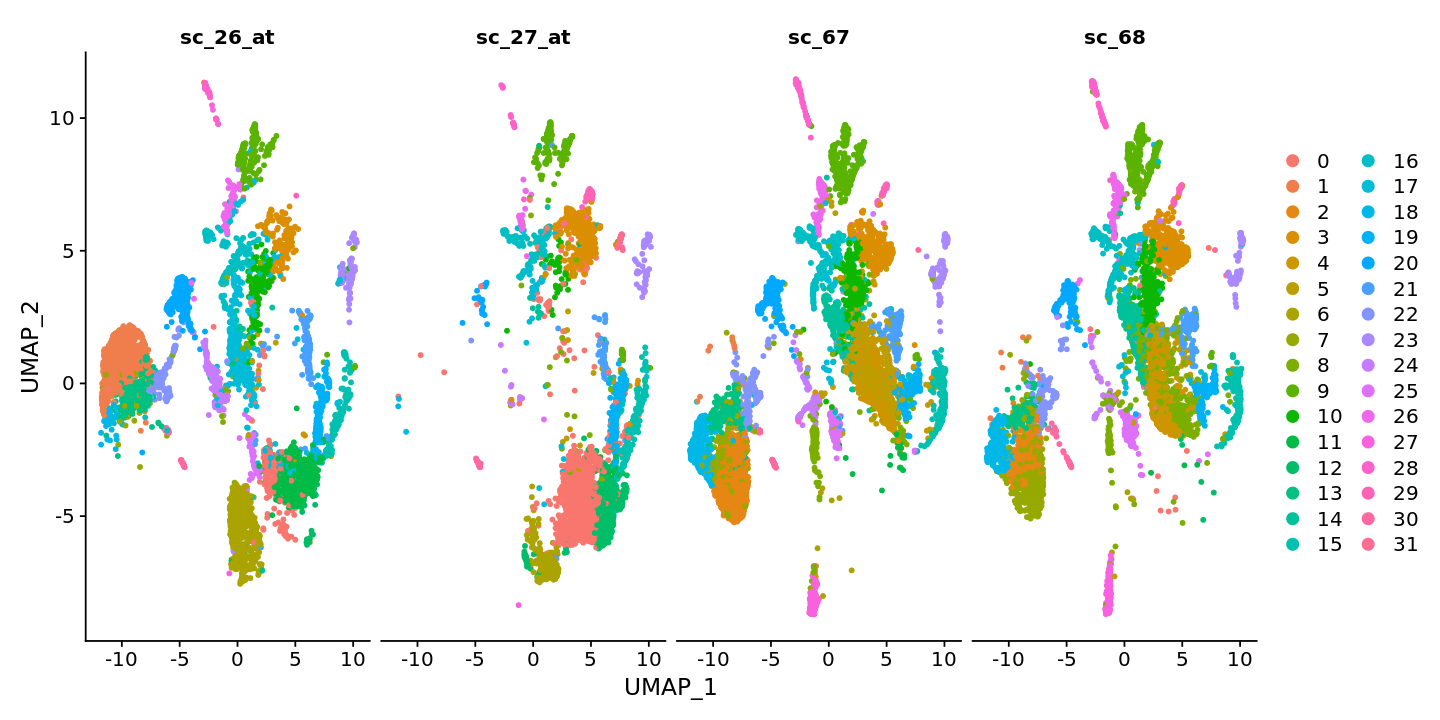

In [6]:
options(repr.plot.width=12, repr.plot.height=6)
DefaultAssay(cwh_intd ) <- "integrated"
DimPlot(cwh_intd, reduction = "umap", label = FALSE, pt.size = 1, split.by = "orig.ident")

In [7]:
cw_unsorted = readRDS("~/data/buckets/single_cell_bucket_3_4_21/Flower_4S_seu3.rds")

In [8]:
cw_list = SplitObject(cw_unsorted, split.by = "orig.ident")

In [9]:
#rename split objects
wt_1_seu = CreateSeuratObject(cw_list[[1]]@assays$RNA@counts)
wt_2_seu = CreateSeuratObject(cw_list[[3]]@assays$RNA@counts)
mut_1_seu = CreateSeuratObject(cw_list[[2]]@assays$RNA@counts)
mut_2_seu = CreateSeuratObject(cw_list[[4]]@assays$RNA@counts)

In [13]:
#set experimental condition
wt_1_seu@meta.data$condition = "wt_unsorted"
wt_2_seu@meta.data$condition = "wt_unsorted"
mut_1_seu@meta.data$condition = "mut_unsorted"
mut_2_seu@meta.data$condition = "mut_unsorted"

#set orig.ident
wt_1_seu@meta.data$orig.ident = "wt_1"
wt_2_seu@meta.data$orig.ident = "wt_2"
mut_1_seu@meta.data$orig.ident = "mut_1"
mut_2_seu@meta.data$orig.ident = "mut_2"

In [12]:
#SCT tranform on split objects
wt_1_seu = SCTransform(wt_1_seu)
wt_2_seu = SCTransform(wt_2_seu)
mut_1_seu = SCTransform(mut_1_seu)
mut_2_seu = SCTransform(mut_2_seu)

DefaultAssay(wt_1_seu) = "SCT"
DefaultAssay(wt_2_seu) = "SCT"
DefaultAssay(mut_1_seu) = "SCT"
DefaultAssay(mut_2_seu) = "SCT"

Calculating cell attributes from input UMI matrix: log_umi



In [ ]:
cwh_ref_intd = seu_integrate(wt_1_seu, wt_2_seu, mut_1_seu, mut_2_seu, filename = "6_16_21_CWH", nfeatures = 3000)

In [11]:
cwh_ref_intd = readRDS(file = "../data/intd_seu_objects/6_16_21_CWH.rds")

15:57:54 Annoy recall = 100%

15:57:54 Commencing smooth kNN distance calibration using 1 thread

15:57:57 Initializing from normalized Laplacian + noise

15:57:58 Commencing optimization for 200 epochs, with 1098974 positive edges

15:58:14 Optimization finished



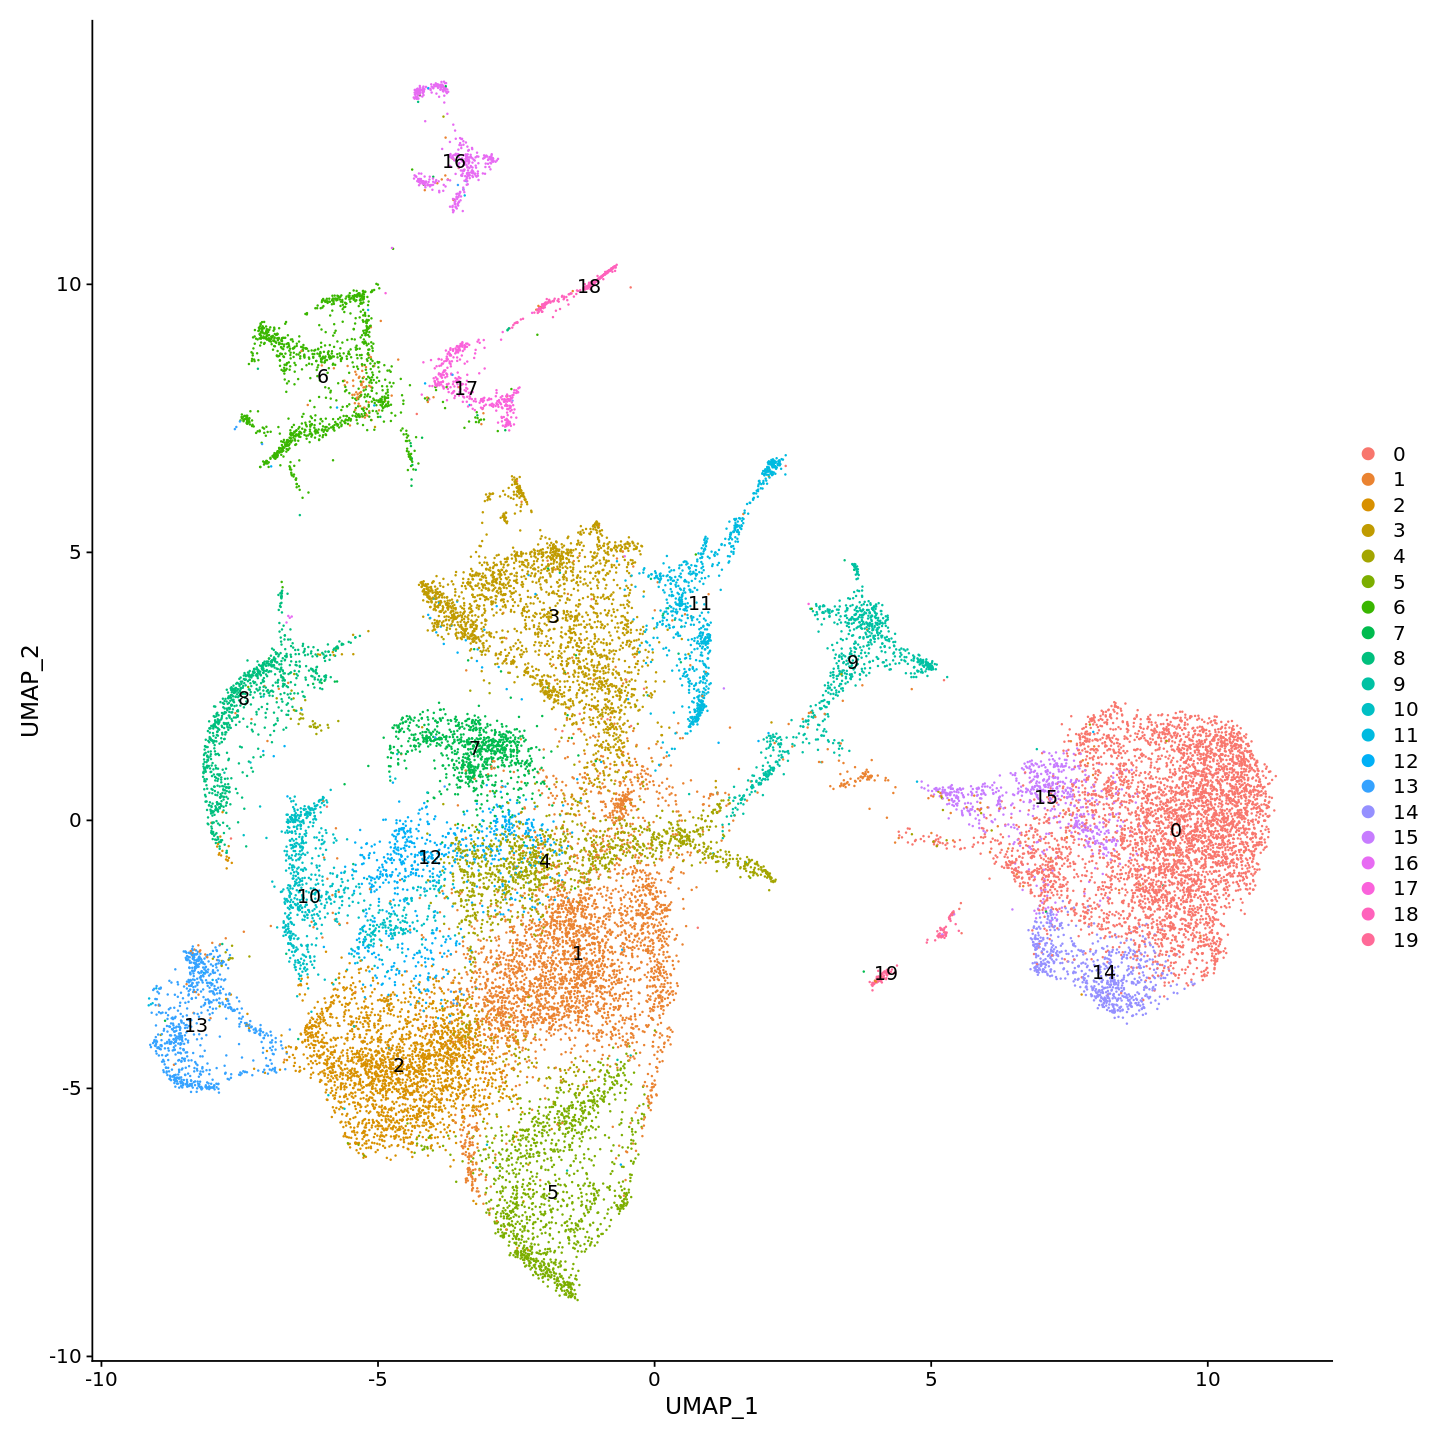

In [16]:
DefaultAssay(cwh_ref_intd) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
cwh_ref_intd <- RunPCA(cwh_ref_intd, npcs = 50, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

cwh_ref_intd <- FindNeighbors(cwh_ref_intd, dims = 1:50)
cwh_ref_intd <- FindClusters(cwh_ref_intd, resolution = 0.5)
cwh_ref_intd <- RunUMAP(cwh_ref_intd, reduction = "pca", dims = 1:50)
DimPlot(cwh_ref_intd, reduction = "umap", label = TRUE)

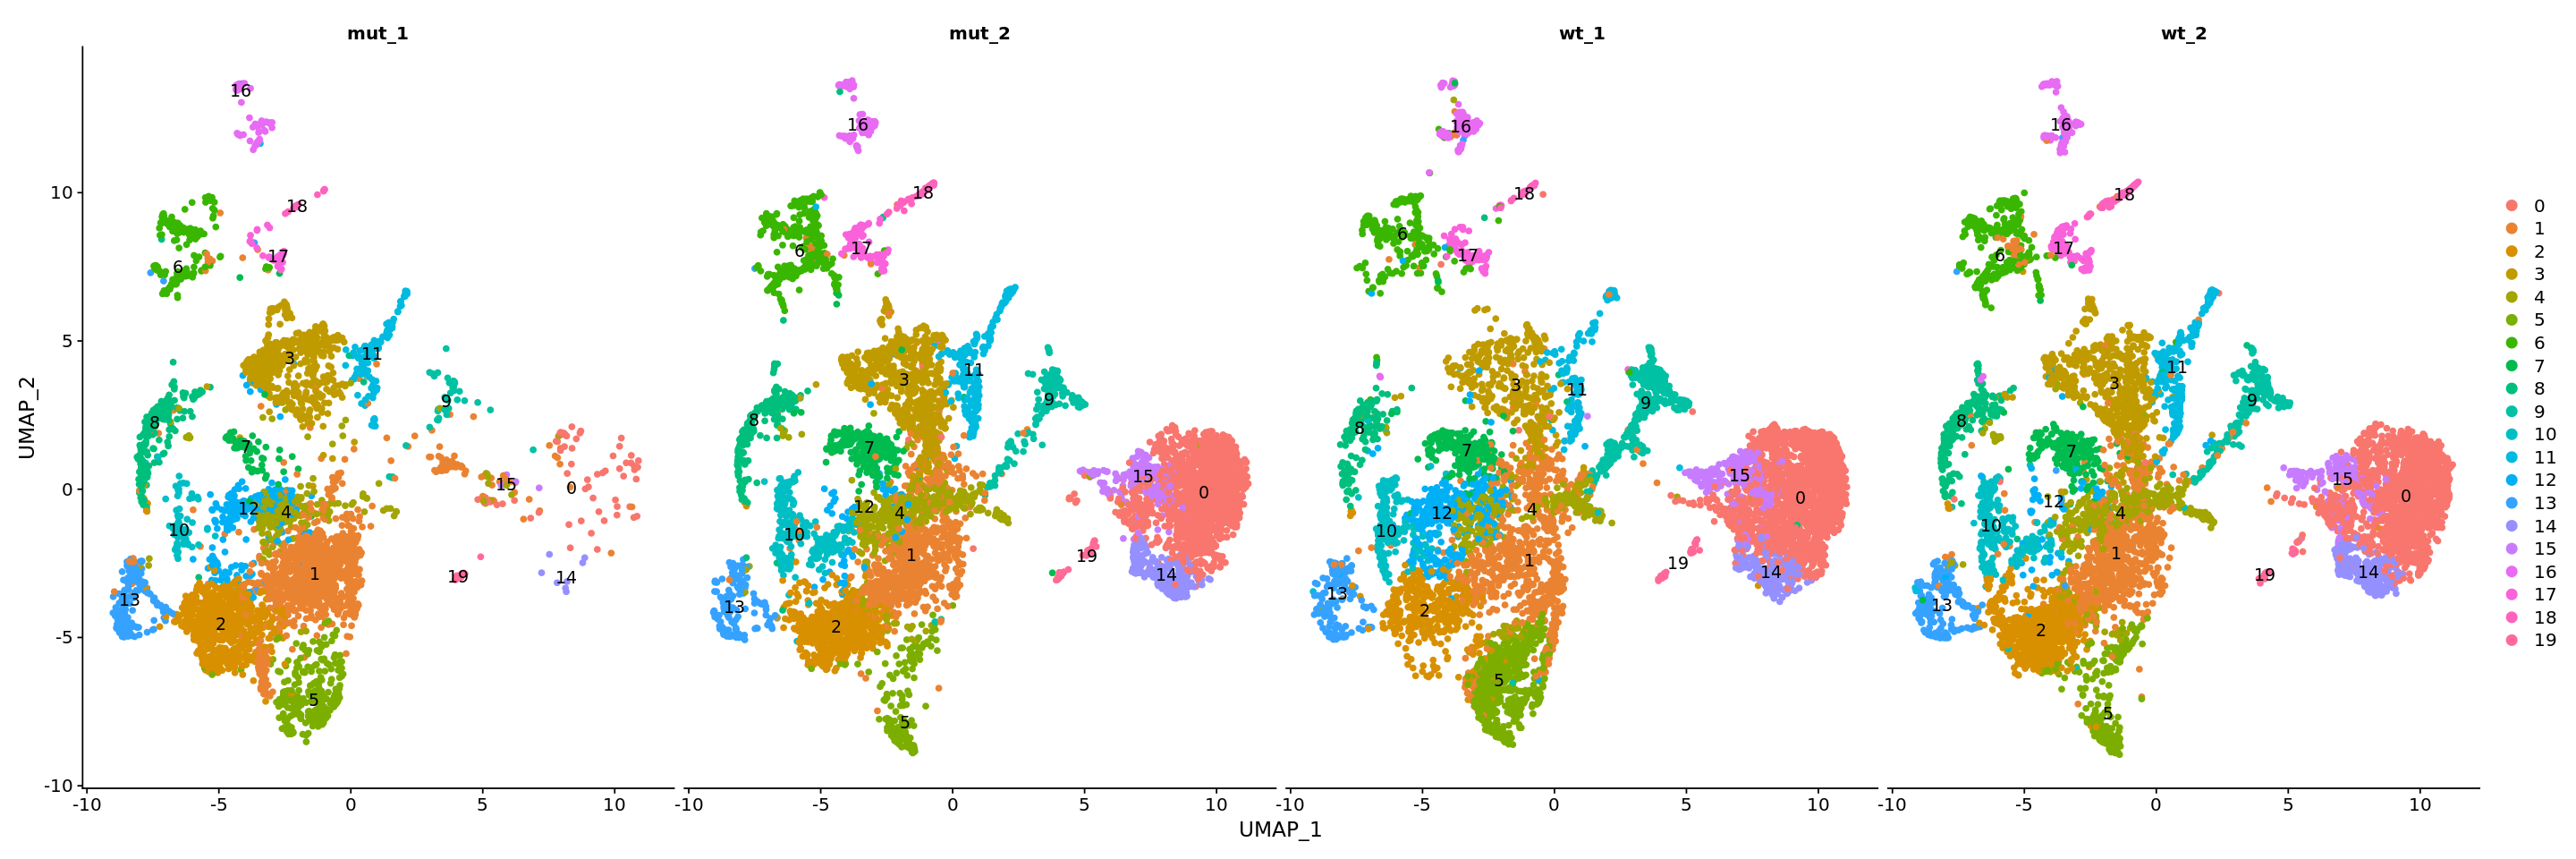

In [17]:
options(repr.plot.width=24, repr.plot.height=8)
DimPlot(cwh_ref_intd, reduction = "umap", label = TRUE, pt.size = 1.5, split.by = "orig.ident")

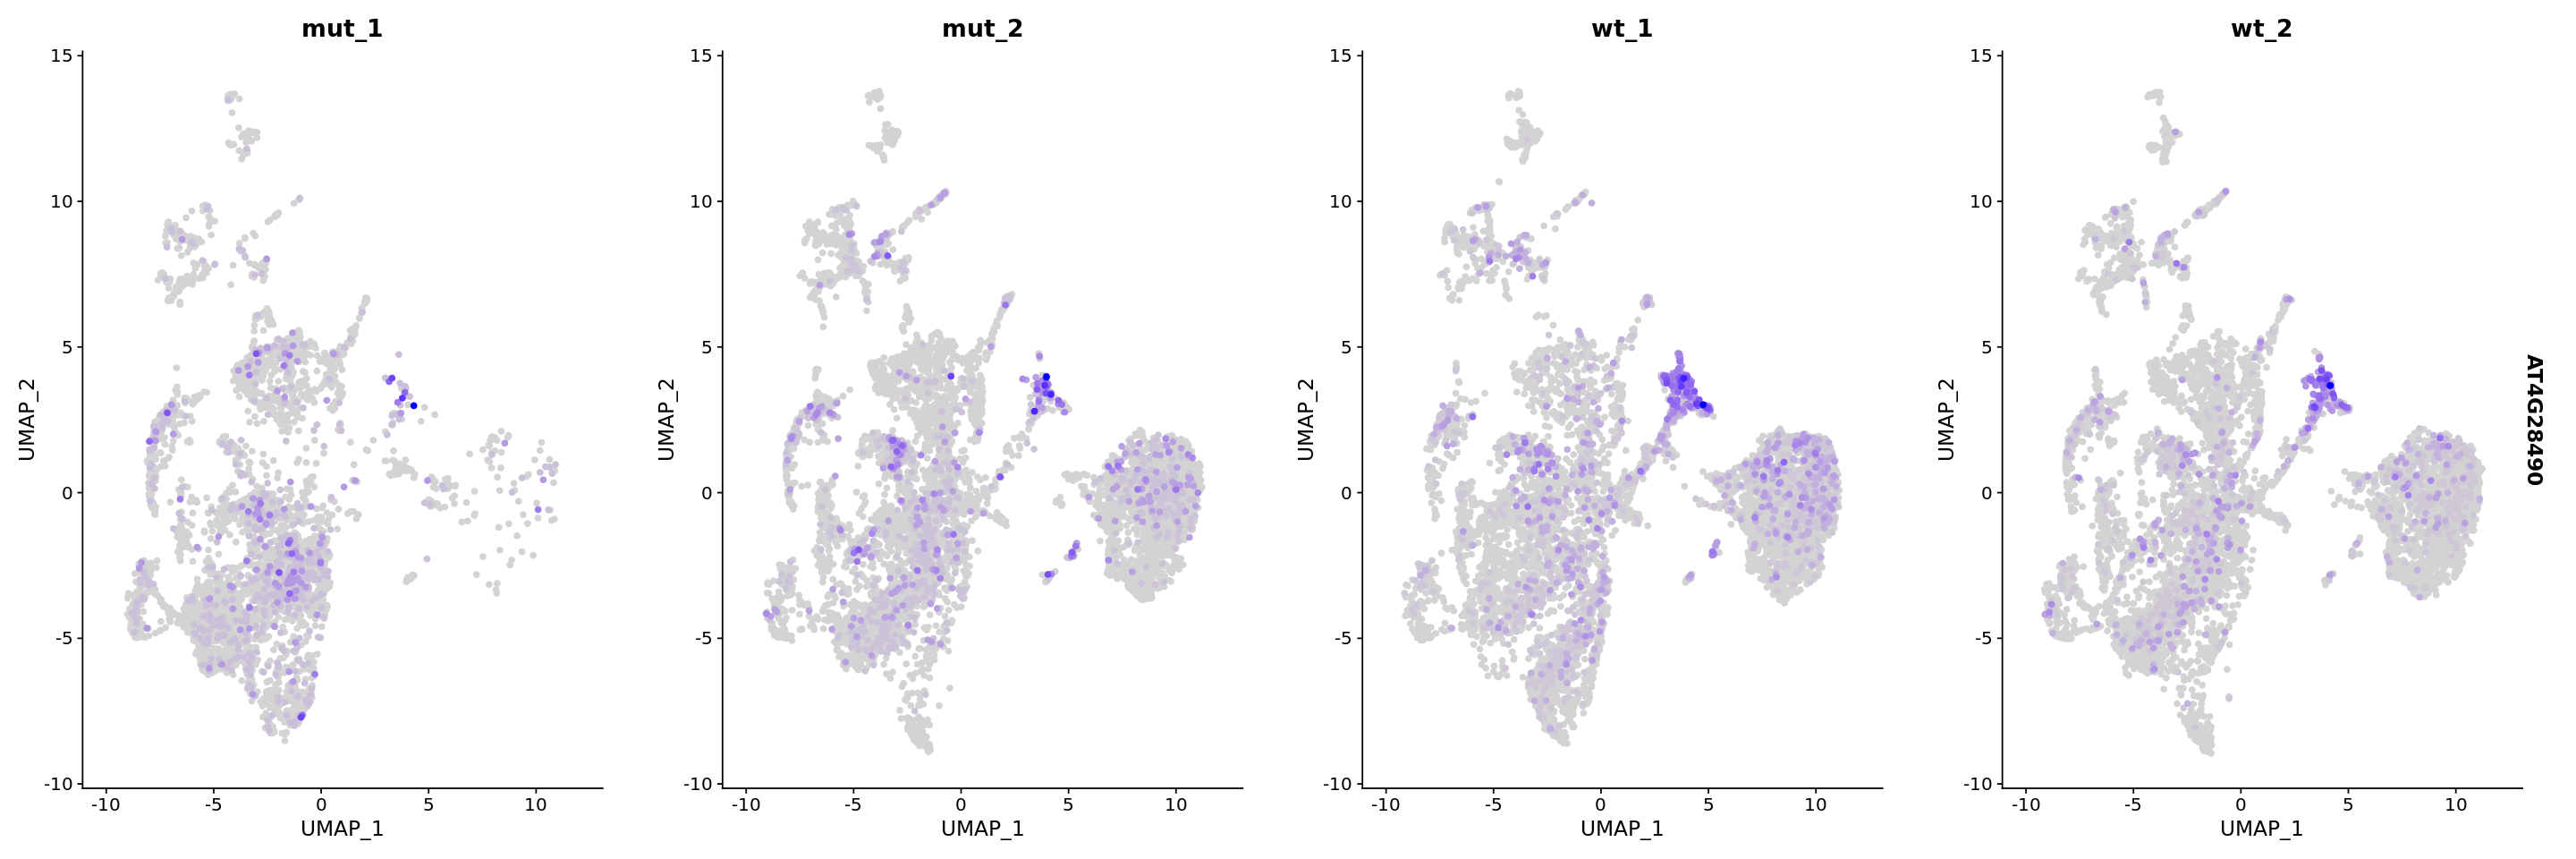

In [18]:
DefaultAssay(cwh_ref_intd) <- "SCT"

#haesa
FeaturePlot(cwh_ref_intd, features = c("AT4G28490"),  pt.size = 1.5, order = TRUE, min = .5, split.by = "orig.ident")# + scale_colour_gradient(low = "gray94", high = "red", space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour")

In [20]:
cluster = "9"
cwh_ref_intd@active.assay = "RNA"

wt_1_AZ <- rowSums(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "wt_1"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "wt_1"), ident = cluster)]))
wt_2_AZ <- rowSums(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "wt_2"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "wt_2"), ident = cluster)]))
mut_1_AZ <- rowSums(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "mut_1"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "mut_1"), ident = cluster)]))
mut_2_AZ <- rowSums(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "mut_2"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "mut_2"), ident = cluster)]))

In [21]:
all_AZ = cbind(wt_1_AZ, wt_2_AZ, mut_1_AZ, mut_2_AZ)
colnames(all_AZ) = c("wt_1_pb", "wt_2_pb", "mut_1_pb", "mut_2_pb")


In [28]:
head(all_AZ)
write.csv(all_AZ, "/home/robotmessenger810/sc_analysis/data/counts/CWH_pbs_AZ.csv")

,wt_1_pb,wt_2_pb,mut_1_pb,mut_2_pb
AT1G01010,117,142,8,14
AT1G01020,81,122,6,22
AT1G03987,0,0,0,0
AT1G01030,2,6,4,1
AT1G01040,59,27,2,8
AT1G01050,258,254,19,19


In [26]:
dim(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "wt_1"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "wt_1"), ident = cluster)]))
dim(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "wt_2"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "wt_2"), ident = cluster)]))
dim(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "mut_1"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "mut_1"), ident = cluster)]))
dim(as.matrix(GetAssayData(subset(cwh_ref_intd, subset = orig.ident == "mut_2"), slot = "counts")[, WhichCells(subset(cwh_ref_intd, subset = orig.ident == "mut_2"), ident = cluster)]))

[1] 27417   380

[1] 27417   216

[1] 27417    37

[1] 27417   167

In [8]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))
# loop
#    for (i in 1:length(seu.list)) {
#         seu.list[[i]]@assays$spliced_RNA <- NULL
#         seu.list[[i]]@assays$spliced_SCT <- NULL
#         seu.list[[i]]@assays$unspliced_RNA <- NULL
#         seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    print(length(to_integrate))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
    rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
 #   }
}